In [27]:
#!pip install ipypb

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pandas import json_normalize

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# 주피터 노트북 과부하가 걸릴 수 있으므로 다시 돌려놓음
# pd.options.display.max_rows = 10

In [29]:
#df = pd.read_csv('C:/Users/pc/Desktop/SPARTA/01. 프로젝트/3. 심화 프로젝트/01. 데이터/train.csv/train.csv', converters={column: json.loads for column in ['device', 'geoNetwork','totals', 'trafficSource']}, dtype={'fullVisitorId': 'str'})
#df = df.sample(n=50000)
#df = df.reset_index()

In [30]:
'''
json_columns = ['device', 'geoNetwork','totals', 'trafficSource']

def get_columns(columns_list: list):
   df2 = df.copy()
   for column in json_columns:
        column_as_df = json_normalize(df2[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df2 = df2.drop(column, axis=1)
        df2 = pd.concat([df2, column_as_df], axis = 1)
   return df2
'''

'\njson_columns = [\'device\', \'geoNetwork\',\'totals\', \'trafficSource\']\n\ndef get_columns(columns_list: list):\n   df2 = df.copy()\n   for column in json_columns:\n        column_as_df = json_normalize(df2[column])\n        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]\n        df2 = df2.drop(column, axis=1)\n        df2 = pd.concat([df2, column_as_df], axis = 1)\n   return df2\n'

In [31]:
#df3 = get_columns(json_columns)

In [32]:
df3 = pd.read_csv('C:/Users/pc/Desktop/SPARTA/01. 프로젝트/3. 심화 프로젝트/01. 데이터/train.csv/result.csv')

# 분석용 데이터 ===============================================

### 변수설명
1. channelGrouping
2. fullVisitorId: 아이디 고유값 
5. visitNumber: 사용자의 세션 숫자, 첫번째 세션이면 1
6. visitStartTime: 타임스탬프           # 질문: 머무르는 시간인가? 아니면 접속 시간인가?
7. device_isMobile: True/False
8. device_deviceCategory: desktop/mobile/tablet
9. geoNetwork_continent: 대륙
10. geoNetwork_country: 국가
11. totals_visits: 1/Null, 세션이 1이면 이벤트 0, 세션이 null이면 어떠한 이벤트x  
12. totals_hits: 세션 내에 히트의 숫자
13. totals_pageviews: 세션 내에 페이지뷰 숫자	
14. totals_bounces: 1/0 , 1이면 아무것도 안하고 이탈
15. totals_newVisits: 첫번째 방문이면 1, 아니면 null
16. totals_transactionRevenue: 거래비용, 나누기 10^6할 것
17. trafficSource_campaign: 캠페인 트래킹 파라미터
18. trafficSource_source: 트레픽 소스의 소스로 검색엔진, 참고호스트네임, 소스url 파라미터
19. trafficSource_medium: 트레픽 소스의 매개체? 
20. trafficSource_keyword: 트래픽 소스의 키워드 
21. trafficSource_isTrueDirect: True/Null, 웹사이트에 직접 작성하였거나 북마크하면 True, 그 외에는 null
22. trafficSource_adwordsClickInfo.slot: 광고 포지션?
23. trafficSource_adwordsClickInfo.adNetworkType: “Google Search", "Content", "Search partners", "Ad Exchange", "Yahoo Japan Search", "Yahoo Japan AFS", “unknown”, 네트워크 타입

### 참고자료
- GA에 대한 자세한 설명: https://analyticsmarketing.co.kr/digital-analytics/google-analytics-basics/2430/

In [33]:
df3 = df3[['channelGrouping', 'fullVisitorId','visitNumber','visitStartTime', 'device_isMobile', 'device_deviceCategory', 'geoNetwork_continent', 'geoNetwork_country',	'totals_visits', 'totals_hits',	'totals_pageviews',	'totals_newVisits','totals_transactionRevenue','trafficSource_campaign','trafficSource_source', 'trafficSource_medium', 'trafficSource_keyword', 'trafficSource_isTrueDirect',	'trafficSource_adwordsClickInfo.slot','trafficSource_adwordsClickInfo.adNetworkType']]
df3.head(10)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   channelGrouping                               50000 non-null  object 
 1   fullVisitorId                                 50000 non-null  uint64 
 2   visitNumber                                   50000 non-null  int64  
 3   visitStartTime                                50000 non-null  object 
 4   device_isMobile                               50000 non-null  bool   
 5   device_deviceCategory                         50000 non-null  object 
 6   geoNetwork_continent                          50000 non-null  object 
 7   geoNetwork_country                            50000 non-null  object 
 8   totals_visits                                 50000 non-null  int64  
 9   totals_hits                                   50000 non-null 

### 01. 데이터 타입변환

In [34]:
'''
# 문자열로
df3['fullVisitorId']=df3['fullVisitorId'].astype(str)
# 날짜로
df3['visitStartTime']=pd.to_datetime(df3['visitStartTime'], unit='s')
# 숫자로(float -> int변환이 안돼서 일단 그대로 둠)
df3['totals_visits']=pd.to_numeric(df3['totals_visits'])
df3['totals_hits']=pd.to_numeric(df3['totals_hits'])
df3['totals_pageviews']=pd.to_numeric(df3['totals_pageviews'])
df3['totals_newVisits']=pd.to_numeric(df3['totals_newVisits'])
df3['totals_transactionRevenue']=pd.to_numeric(df3['totals_transactionRevenue'])
'''

df3['visitStartTime']=pd.to_datetime(df3['visitStartTime'])

### 02. 인코딩
- trafficSource_campaign_en 컬럼 생성: 1이면 캠페인을 통해, 0이면 캠페인을 통하지않음
- total_transactionRevevenue 수정: 'nan'값을 0으로 수정 및 /10^6
- totals_newVisits 수정: null을 0으로 수정함 -> 1이면 첫방문 , 아니면 0

In [35]:
# trafficSource_campaign 인코딩
def get_cam(x):
    if x == '(not set)':
        return 0
    else:
        return 1

df3['trafficSource_campaign_en'] = df3['trafficSource_campaign'].apply(get_cam)

# totals_transactionRevenue 인코딩(nan -> 0)
df3['totals_transactionRevenue'].fillna(0, inplace=True)
#df3['totals_transactionRevenue']=np.power(df3['totals_transactionRevenue'],1/6).round(2)

# totals_transactionRevenue_en 컬럼생성
def get_revenue(x):
    if x == 0:
        return 0
    else:
        return 1

df3['totals_transactionRevenue_en'] = df3['totals_transactionRevenue'].apply(get_revenue)

# null -> 0으로
df3['totals_newVisits'].fillna(0, inplace=True)

In [36]:
df3.nunique()

channelGrouping                                     8
fullVisitorId                                   48391
visitNumber                                       166
visitStartTime                                  49946
device_isMobile                                     2
device_deviceCategory                               3
geoNetwork_continent                                6
geoNetwork_country                                180
totals_visits                                       1
totals_hits                                       139
totals_pageviews                                  108
totals_newVisits                                    2
totals_transactionRevenue                         402
trafficSource_campaign                              8
trafficSource_source                              136
trafficSource_medium                                7
trafficSource_keyword                             376
trafficSource_isTrueDirect                          1
trafficSource_adwordsClickIn

In [37]:
# 첫방문에 따른 구매건수 비교
df3.groupby(['totals_newVisits','totals_transactionRevenue_en'])['totals_transactionRevenue_en'].count()
# 96%, 4% // 99% , 1%

totals_newVisits  totals_transactionRevenue_en
0.0               0                               10651
                  1                                 401
1.0               0                               38696
                  1                                 252
Name: totals_transactionRevenue_en, dtype: int64

### 03-1. 코호트분석(기간 내에 첫방문 한 전체 대상자)

https://data-marketing-bk.tistory.com/entry/Python-COHORT-%EB%B6%84%EC%84%9D-%EA%B0%9C%EB%85%90%EB%B6%80%ED%84%B0-%EC%8B%A4%EC%A0%84-%EC%BD%94%EB%93%9C%EA%B9%8C%EC%A7%80-feat-%EB%B6%84%EC%84%9D-%EC%98%88%EC%A0%9C-%ED%8F%AC%ED%95%A8

In [38]:
# visitCycle : 방문 년도 + 월
df3['visitCycle'] = df3['visitStartTime'].dt.strftime('%Y.%m')
# first_visit: 첫방문 
first_visit = df3.groupby('fullVisitorId')['visitStartTime'].min()
first_visit.sort_values()
first_visit.count()

df3 = df3.set_index('fullVisitorId')
df3['First_visit_month'] = first_visit.dt.strftime('%Y.%m')
df3.reset_index(inplace=True)

In [39]:
co1 = df3.groupby(['First_visit_month', 'visitCycle'])['fullVisitorId'].nunique()
co1 = co1.reset_index()
co1

,First_visit_month,visitCycle,fullVisitorId
0,2016.08,2016.08,3972
1,2016.08,2016.09,39
2,2016.08,2016.10,18
3,2016.08,2016.11,11
4,2016.08,2016.12,16
...,...,...,...
73,2017.06,2017.07,22
74,2017.06,2017.08,2
75,2017.07,2017.07,3822
76,2017.07,2017.08,4


In [40]:
from ipypb import ipb
temp1=[]

for i in ipb(range(co1.shape[0])):
    f_first_visit1 = pd.to_datetime(co1.First_visit_month[i]).to_period('M')
    f_visit_cycle1 = pd.to_datetime(co1.visitCycle[i]).to_period('M')
    
    month_diff1 = (f_visit_cycle1 - f_first_visit1).n
    temp1.append(month_diff1)

co1['CohortPeriod'] = temp1
co1.sample(5)

 [████████████████████████████████████████████████████████████] 78/78 [00:00<00:00, 0.00s/it]

,First_visit_month,visitCycle,fullVisitorId,CohortPeriod
71,2017.05,2017.07,8,2
23,2016.10,2017.01,6,3
4,2016.08,2016.12,16,4
20,2016.10,2016.10,5229,0
33,2016.11,2017.03,6,4


In [51]:
co_retention1 = co1.set_index(['First_visit_month', 'CohortPeriod'])
co_retention1 = co_retention1['fullVisitorId'].unstack(1)
retention1 = co_retention1.div(co_retention1[0], axis=0)
retention1 = retention1 * 100
retention1.round(2)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
First_visit_month,,,,,,,,,,,,
2016.08,100.0,0.98,0.45,0.28,0.40,0.18,0.13,0.13,0.03,0.05,0.03,0.05
2016.09,100.0,0.88,0.31,0.08,0.05,NaN,0.08,0.08,NaN,0.03,NaN,NaN
2016.10,100.0,0.94,0.36,0.11,0.13,0.08,0.04,0.08,NaN,0.02,NaN,NaN
2016.11,100.0,0.55,0.24,0.06,0.10,0.06,0.06,0.02,0.02,NaN,NaN,NaN
2016.12,100.0,0.76,0.44,0.25,0.15,0.10,0.05,0.02,NaN,NaN,NaN,NaN
2017.01,100.0,0.98,0.37,0.06,0.20,0.09,0.12,NaN,NaN,NaN,NaN,NaN
2017.02,100.0,0.84,0.18,0.18,0.12,0.06,0.03,NaN,NaN,NaN,NaN,NaN
2017.03,100.0,0.56,0.24,0.05,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,0.73,0.23,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortPeriod', ylabel='First_visit_month'>

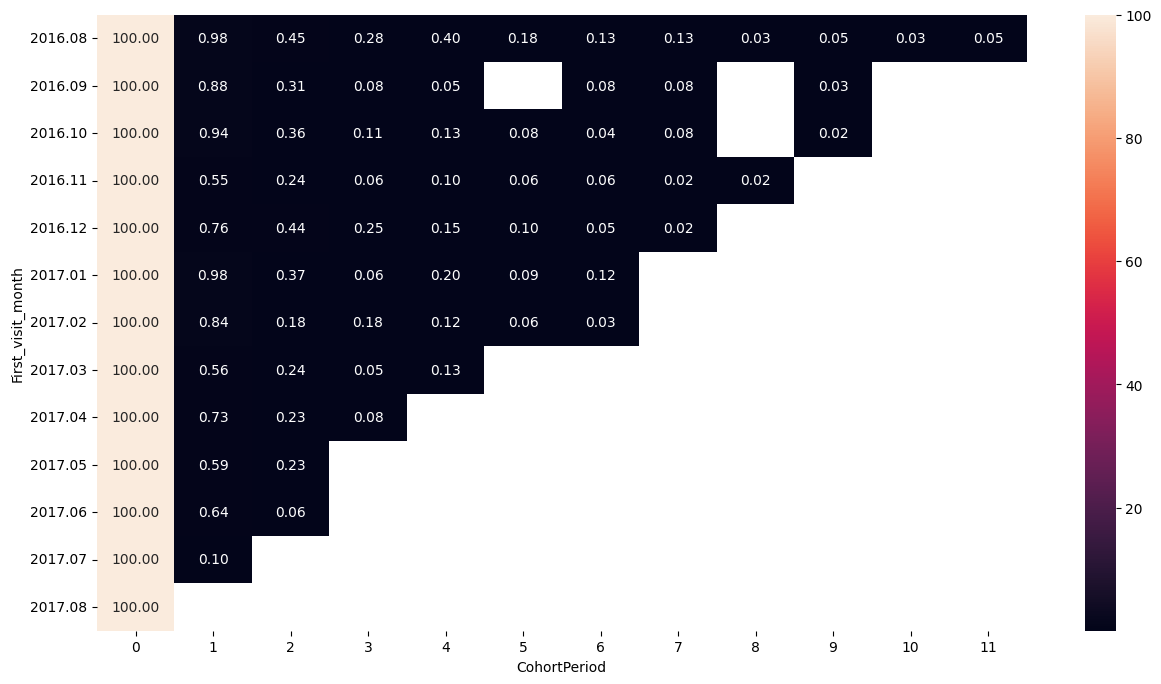

In [65]:
xticks = np.arange(0, 12)
yticks = ['2016.08', '2016.09', '2016.10', '2016.11', '2016.12', '2017.01', '2017.02', '2017.03', '2017.04', '2017.05', '2017.06', '2017.07', '2017.08']

plt.figure(figsize = (15, 8))
sns.heatmap(retention1, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.2f')

### 03-2. 코호트분석(물품구매자 대상)

In [42]:
df4 = df3[df3['totals_transactionRevenue'] != 0]
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 653 entries, 100 to 49883
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   fullVisitorId                                 653 non-null    uint64        
 1   channelGrouping                               653 non-null    object        
 2   visitNumber                                   653 non-null    int64         
 3   visitStartTime                                653 non-null    datetime64[ns]
 4   device_isMobile                               653 non-null    bool          
 5   device_deviceCategory                         653 non-null    object        
 6   geoNetwork_continent                          653 non-null    object        
 7   geoNetwork_country                            653 non-null    object        
 8   totals_visits                                 653 non-null    int64    

In [52]:
co2 = df4.groupby(['First_visit_month', 'visitCycle'])['fullVisitorId'].nunique()
co2 = co2.reset_index()

from ipypb import ipb
temp2=[]

for i in ipb(range(co2.shape[0])):
    f_first_visit2 = pd.to_datetime(co2.First_visit_month[i]).to_period('M')
    f_visit_cycle2 = pd.to_datetime(co2.visitCycle[i]).to_period('M')
    
    month_diff2 = (f_visit_cycle2 - f_first_visit2).n
    temp2.append(month_diff2)

co2['CohortPeriod'] = temp2

co_retention2 = co2.set_index(['First_visit_month', 'CohortPeriod'])
co_retention2 = co_retention2['fullVisitorId'].unstack(1)
retention2 = co_retention2.div(co_retention2[0], axis=0)

retention2 = retention2 * 100
retention2.round(2)

 [############################################################] 0/31 [0<0, 0.00s/it]

CohortPeriod,0,1,2,3,4,5
First_visit_month,,,,,,
2016.08,100.0,1.59,NaN,NaN,NaN,NaN
2016.09,100.0,5.66,NaN,NaN,NaN,NaN
2016.10,100.0,6.52,6.52,NaN,NaN,2.17
2016.11,100.0,1.64,NaN,NaN,1.64,NaN
2016.12,100.0,NaN,NaN,1.32,NaN,2.63
2017.01,100.0,3.12,9.38,NaN,3.12,NaN
2017.02,100.0,2.22,2.22,NaN,NaN,NaN
2017.03,100.0,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,NaN,4.76,NaN,NaN,NaN


<Axes: xlabel='CohortPeriod', ylabel='First_visit_month'>

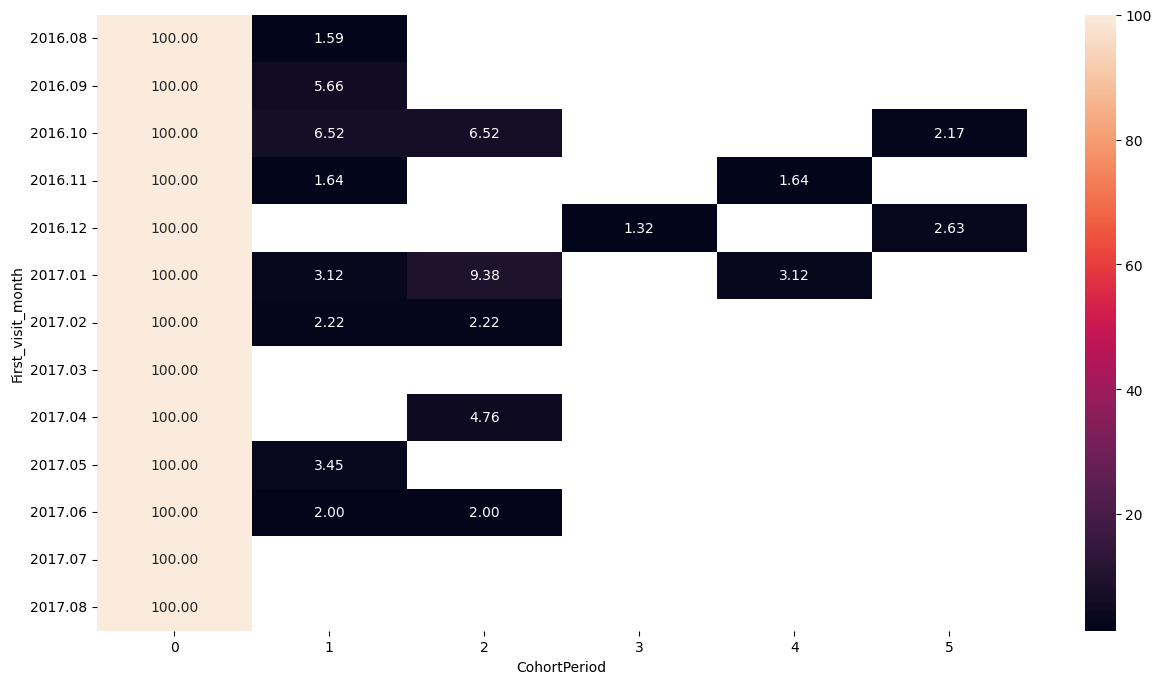

In [66]:
xticks = np.arange(0, 6)
yticks = ['2016.08', '2016.09', '2016.10', '2016.11', '2016.12', '2017.01', '2017.02', '2017.03', '2017.04', '2017.05', '2017.06', '2017.07', '2017.08']

plt.figure(figsize = (15, 8))
sns.heatmap(retention2, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.2f')

### 03-3. 코호트분석(캠페인x 고객)

In [44]:
df5 = df3[df3['trafficSource_campaign'] == '(not set)']
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47778 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   fullVisitorId                                 47778 non-null  uint64        
 1   channelGrouping                               47778 non-null  object        
 2   visitNumber                                   47778 non-null  int64         
 3   visitStartTime                                47778 non-null  datetime64[ns]
 4   device_isMobile                               47778 non-null  bool          
 5   device_deviceCategory                         47778 non-null  object        
 6   geoNetwork_continent                          47778 non-null  object        
 7   geoNetwork_country                            47778 non-null  object        
 8   totals_visits                                 47778 non-null  int64    

In [53]:
co3 = df5.groupby(['First_visit_month', 'visitCycle'])['fullVisitorId'].nunique()
co3 = co3.reset_index()

from ipypb import ipb
temp3=[]

for i in ipb(range(co3.shape[0])):
    f_first_visit3 = pd.to_datetime(co3.First_visit_month[i]).to_period('M')
    f_visit_cycle3 = pd.to_datetime(co3.visitCycle[i]).to_period('M')
    
    month_diff3 = (f_visit_cycle3 - f_first_visit3).n
    temp3.append(month_diff3)

co3['CohortPeriod'] = temp3

co_retention3 = co3.set_index(['First_visit_month', 'CohortPeriod'])
co_retention3 = co_retention3['fullVisitorId'].unstack(1)
retention3 = co_retention3.div(co_retention3[0], axis=0)

retention3 = retention3 * 100
retention3.round(2)

 [████████████████████████████████████████████████████████████] 78/78 [00:00<00:00, 0.00s/it]

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
First_visit_month,,,,,,,,,,,,
2016.08,100.0,1.03,0.42,0.26,0.40,0.18,0.13,0.11,0.03,0.05,0.03,0.05
2016.09,100.0,0.86,0.32,0.05,0.05,NaN,0.05,0.08,NaN,0.03,NaN,NaN
2016.10,100.0,0.95,0.35,0.12,0.14,0.08,0.04,0.06,NaN,0.02,NaN,NaN
2016.11,100.0,0.55,0.25,0.07,0.08,0.07,0.07,0.02,0.02,NaN,NaN,NaN
2016.12,100.0,0.80,0.41,0.26,0.16,0.10,0.05,0.03,NaN,NaN,NaN,NaN
2017.01,100.0,0.97,0.33,0.06,0.18,0.09,0.12,NaN,NaN,NaN,NaN,NaN
2017.02,100.0,0.81,0.19,0.16,0.13,0.06,0.03,NaN,NaN,NaN,NaN,NaN
2017.03,100.0,0.55,0.25,0.06,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,0.76,0.24,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortPeriod', ylabel='First_visit_month'>

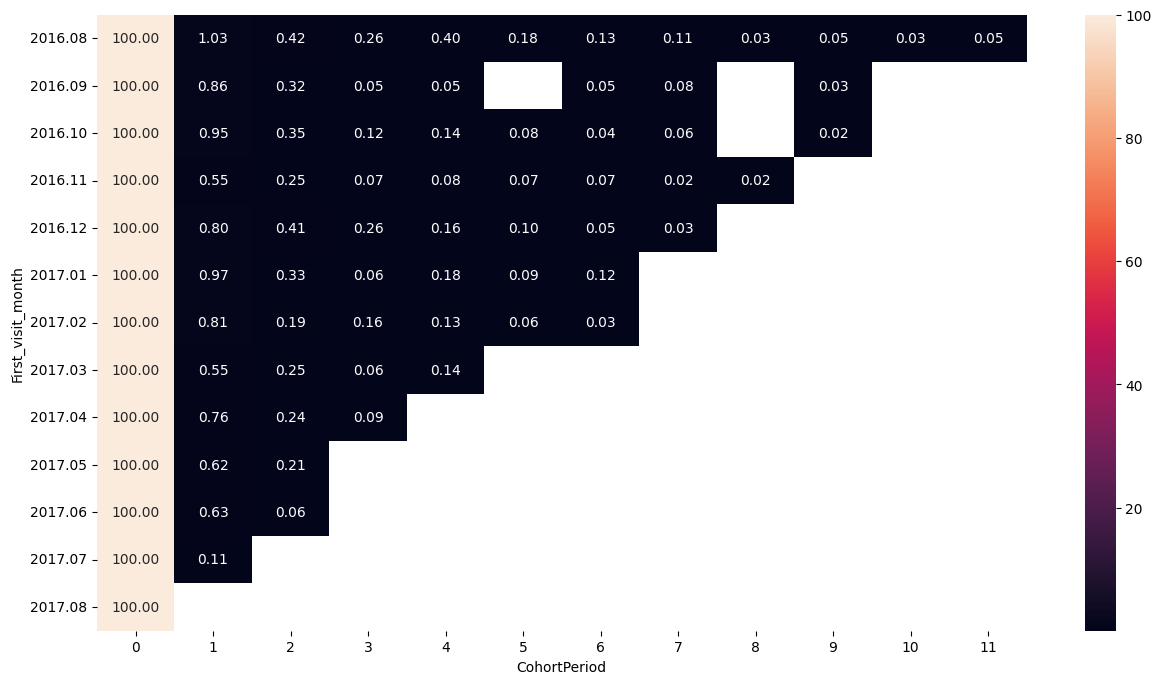

In [67]:
xticks = np.arange(0, 12)
yticks = ['2016.08', '2016.09', '2016.10', '2016.11', '2016.12', '2017.01', '2017.02', '2017.03', '2017.04', '2017.05', '2017.06', '2017.07', '2017.08']

plt.figure(figsize = (15, 8))
sns.heatmap(retention3, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.2f')

### 03-4. 코호트분석(캠페인을 통한 고객)

In [46]:
df6 = df3[df3['trafficSource_campaign'] != '(not set)']
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2222 entries, 7 to 49965
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   fullVisitorId                                 2222 non-null   uint64        
 1   channelGrouping                               2222 non-null   object        
 2   visitNumber                                   2222 non-null   int64         
 3   visitStartTime                                2222 non-null   datetime64[ns]
 4   device_isMobile                               2222 non-null   bool          
 5   device_deviceCategory                         2222 non-null   object        
 6   geoNetwork_continent                          2222 non-null   object        
 7   geoNetwork_country                            2222 non-null   object        
 8   totals_visits                                 2222 non-null   int64     

In [50]:
co4 = df6.groupby(['First_visit_month', 'visitCycle'])['fullVisitorId'].nunique()
co4 = co4.reset_index()

from ipypb import ipb
temp4=[]

for i in ipb(range(co4.shape[0])):
    f_first_visit4 = pd.to_datetime(co4.First_visit_month[i]).to_period('M')
    f_visit_cycle4 = pd.to_datetime(co4.visitCycle[i]).to_period('M')
    
    month_diff4 = (f_visit_cycle4 - f_first_visit4).n
    temp4.append(month_diff4)

co4['CohortPeriod'] = temp4

co_retention4 = co4.set_index(['First_visit_month', 'CohortPeriod'])
co_retention4 = co_retention4['fullVisitorId'].unstack(1)
retention4 = co_retention4.div(co_retention4[0], axis=0)

retention4 = retention4 * 100
retention4.round(2)

 [############################################################] 0/34 [0<0, 0.00s/it]

CohortPeriod,0,1,2,3,4,6,7
First_visit_month,,,,,,,
2016.08,100.0,NaN,1.11,0.56,0.56,NaN,0.56
2016.09,100.0,1.60,NaN,0.80,NaN,0.8,NaN
2016.10,100.0,0.65,0.65,NaN,NaN,NaN,0.65
2016.11,100.0,0.49,NaN,NaN,0.49,NaN,NaN
2016.12,100.0,NaN,0.98,NaN,NaN,NaN,NaN
2017.01,100.0,1.14,1.14,NaN,0.57,NaN,NaN
2017.02,100.0,1.38,NaN,0.69,NaN,NaN,NaN
2017.03,100.0,0.66,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortPeriod', ylabel='First_visit_month'>

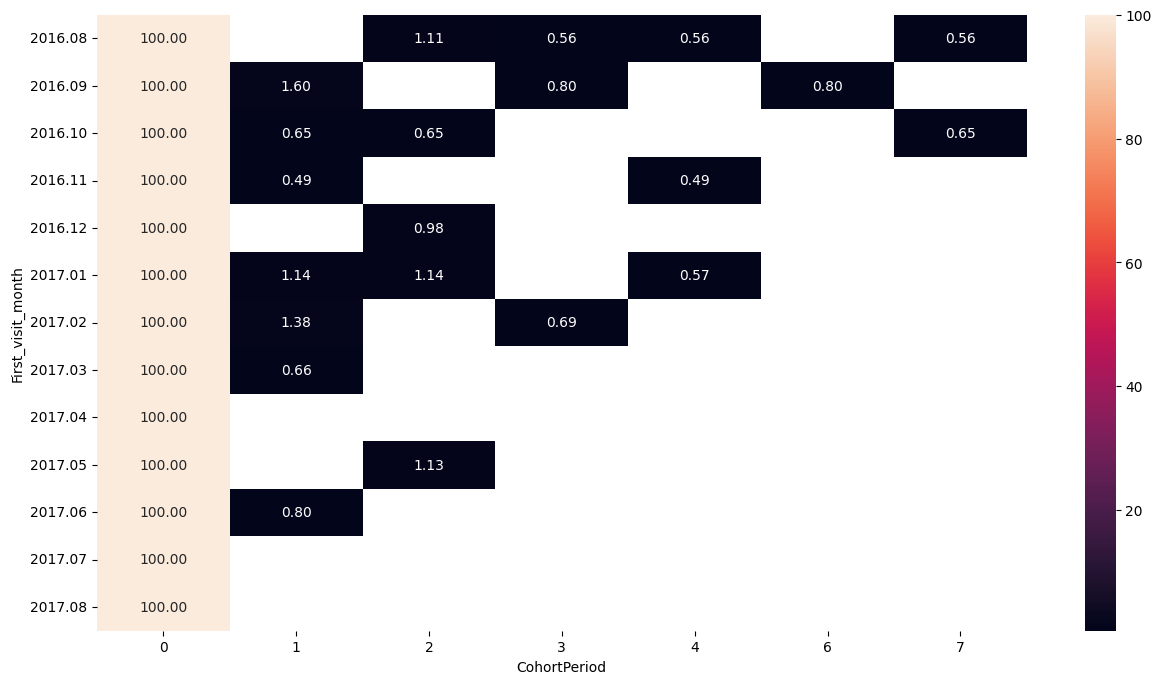

In [69]:
xticks = [0,1,2,3,4,6,7]
yticks = ['2016.08', '2016.09', '2016.10', '2016.11', '2016.12', '2017.01', '2017.02', '2017.03', '2017.04', '2017.05', '2017.06', '2017.07', '2017.08']

plt.figure(figsize = (15, 8))
sns.heatmap(retention4, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.2f')

### 04. 코호트분석(첫구매 후 재방문율)

### 전체 비교

In [54]:
print('전체=========================================')
display(retention1.round(2))
print('구매자=========================================')
display(retention2.round(2))
print('no 캠페인=========================================')
display(retention3.round(2))
print('캠페인=========================================')
display(retention4.round(2))

전체=========================================


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
First_visit_month,,,,,,,,,,,,
2016.08,100.0,0.98,0.45,0.28,0.40,0.18,0.13,0.13,0.03,0.05,0.03,0.05
2016.09,100.0,0.88,0.31,0.08,0.05,NaN,0.08,0.08,NaN,0.03,NaN,NaN
2016.10,100.0,0.94,0.36,0.11,0.13,0.08,0.04,0.08,NaN,0.02,NaN,NaN
2016.11,100.0,0.55,0.24,0.06,0.10,0.06,0.06,0.02,0.02,NaN,NaN,NaN
2016.12,100.0,0.76,0.44,0.25,0.15,0.10,0.05,0.02,NaN,NaN,NaN,NaN
2017.01,100.0,0.98,0.37,0.06,0.20,0.09,0.12,NaN,NaN,NaN,NaN,NaN
2017.02,100.0,0.84,0.18,0.18,0.12,0.06,0.03,NaN,NaN,NaN,NaN,NaN
2017.03,100.0,0.56,0.24,0.05,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,0.73,0.23,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


구매자=========================================


CohortPeriod,0,1,2,3,4,5
First_visit_month,,,,,,
2016.08,100.0,1.59,NaN,NaN,NaN,NaN
2016.09,100.0,5.66,NaN,NaN,NaN,NaN
2016.10,100.0,6.52,6.52,NaN,NaN,2.17
2016.11,100.0,1.64,NaN,NaN,1.64,NaN
2016.12,100.0,NaN,NaN,1.32,NaN,2.63
2017.01,100.0,3.12,9.38,NaN,3.12,NaN
2017.02,100.0,2.22,2.22,NaN,NaN,NaN
2017.03,100.0,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,NaN,4.76,NaN,NaN,NaN


no 캠페인=========================================


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
First_visit_month,,,,,,,,,,,,
2016.08,100.0,1.03,0.42,0.26,0.40,0.18,0.13,0.11,0.03,0.05,0.03,0.05
2016.09,100.0,0.86,0.32,0.05,0.05,NaN,0.05,0.08,NaN,0.03,NaN,NaN
2016.10,100.0,0.95,0.35,0.12,0.14,0.08,0.04,0.06,NaN,0.02,NaN,NaN
2016.11,100.0,0.55,0.25,0.07,0.08,0.07,0.07,0.02,0.02,NaN,NaN,NaN
2016.12,100.0,0.80,0.41,0.26,0.16,0.10,0.05,0.03,NaN,NaN,NaN,NaN
2017.01,100.0,0.97,0.33,0.06,0.18,0.09,0.12,NaN,NaN,NaN,NaN,NaN
2017.02,100.0,0.81,0.19,0.16,0.13,0.06,0.03,NaN,NaN,NaN,NaN,NaN
2017.03,100.0,0.55,0.25,0.06,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,0.76,0.24,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


캠페인=========================================


CohortPeriod,0,1,2,3,4,6,7
First_visit_month,,,,,,,
2016.08,100.0,NaN,1.11,0.56,0.56,NaN,0.56
2016.09,100.0,1.60,NaN,0.80,NaN,0.8,NaN
2016.10,100.0,0.65,0.65,NaN,NaN,NaN,0.65
2016.11,100.0,0.49,NaN,NaN,0.49,NaN,NaN
2016.12,100.0,NaN,0.98,NaN,NaN,NaN,NaN
2017.01,100.0,1.14,1.14,NaN,0.57,NaN,NaN
2017.02,100.0,1.38,NaN,0.69,NaN,NaN,NaN
2017.03,100.0,0.66,NaN,NaN,NaN,NaN,NaN
2017.04,100.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#df3.to_csv('./result.csv')